In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score

import joblib

In [2]:
data = pd.read_csv("../data/processed/scaled_EURUSD_daily.csv", index_col=0, parse_dates=True)
data.head()

,Open,High,Low,Close,MA20,MA50,Rolling_STD,Daily_Return,Volatility,Upper_Band,...,High_Low_Diff,Volatility_Price_Ratio,Momentum,Rolling_Return_5d,MA20_MA50_Interaction,Close_Volatility_Interaction,EMA20,EMA50,MACD,Signal_Line
date,,,,,,,,,,,,,,,,,,,,,
2014-11-23,2.191889,2.257424,2.252358,2.192606,2.266625,1.613936,-0.412957,0.954561,2.01357,2.215342,...,-0.160033,-0.556635,0.550805,1.092093,2.015158,2.658475,2.219578,2.257584,0.092931,0.093239
2014-11-24,2.308272,2.330381,2.312030,2.302185,2.266625,1.613936,-0.412957,0.954561,2.01357,2.215342,...,0.022916,-0.563156,0.550805,1.092093,2.015158,2.689204,2.230200,2.262066,0.128314,0.100489
2014-11-25,2.389062,2.416758,2.384088,2.391431,2.266625,1.613936,-0.412957,0.775757,2.01357,2.215342,...,0.219317,-0.568423,0.550805,1.092093,2.015158,2.714231,2.248461,2.270022,0.187758,0.118470
2014-11-26,2.439155,2.409953,2.424995,2.439066,2.266625,1.613936,-0.412957,0.417363,2.01357,2.215342,...,-0.464050,-0.571217,0.550805,1.092093,2.015158,2.727590,2.269600,2.279614,0.254458,0.146521
2014-11-27,2.350267,2.350416,2.359130,2.356410,2.266625,1.613936,-0.412957,-0.694317,2.01357,2.215342,...,-0.367195,-0.566361,0.550805,1.092093,2.015158,2.704410,2.280713,2.285450,0.285147,0.175250


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2608 entries, 2014-11-23 to 2024-11-22
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open                          2608 non-null   float64
 1   High                          2608 non-null   float64
 2   Low                           2608 non-null   float64
 3   Close                         2608 non-null   float64
 4   MA20                          2608 non-null   float64
 5   MA50                          2608 non-null   float64
 6   Rolling_STD                   2608 non-null   float64
 7   Daily_Return                  2608 non-null   float64
 8   Volatility                    2608 non-null   float64
 9   Upper_Band                    2608 non-null   float64
 10  Lower_Band                    2608 non-null   float64
 11  Bollinger_Bandwidth           2608 non-null   float64
 12  Lag1_Close                    2608 non-null 

## Split data into Training and Testing Sets

In [4]:
target = 'Close'
features = [col for col in data.columns if col != target]

train_size = int(len(data) * 0.8)

train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (2086, 32), (2086,)
Testing set: (522, 32), (522,)


## Find Optimal parameter Set

In [5]:
def evaluate_feature_counts(max_features):
    results = {}
    for n in range(3, max_features + 1):
        rfe = RFE(estimator=XGBRegressor(random_state=42), n_features_to_select=n)
        rfe.fit(X_train, y_train)
        selected_features = X_train.columns[rfe.support_]
        
        # Cross-validate on selected features
        xgb_model = XGBRegressor(random_state=42)
        cv_scores = cross_val_score(xgb_model, X_train[selected_features], y_train, 
                                    cv=5, scoring='neg_mean_squared_error')
        results[n] = -np.mean(cv_scores)
    
    return results

feature_results = evaluate_feature_counts(max_features=20)
print("Feature results:", feature_results)

Feature results: {3: 0.03160878696194487, 4: 0.033539723791665484, 5: 0.03359810836133723, 6: 0.033729184640550344, 7: 0.03317554848888757, 8: 0.033548476140698225, 9: 0.033583904975506326, 10: 0.03374015463812073, 11: 0.0333994710599228, 12: 0.033414301750106276, 13: 0.03351625490568552, 14: 0.03370727351100557, 15: 0.03394540972354033, 16: 0.03424561488928244, 17: 0.034018395716074165, 18: 0.033544683118318, 19: 0.033542408748884936, 20: 0.03362438955901777}


In [6]:
optimal_features = min(feature_results, key=feature_results.get)
final_rfe = RFE(estimator=XGBRegressor(random_state=42), n_features_to_select=optimal_features, step=1)
final_rfe.fit(X_train, y_train)
selected_features = X_train.columns[final_rfe.support_]

print(f"Selected Features by RFE: {list(selected_features)}")

Selected Features by RFE: ['Open', 'High', 'Low']


## Optimal Features for XGBoost:
- `Open`
- `High`
- `Low`

In [7]:
# Subset to only include selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Train model with the selected features
xgb_selected = XGBRegressor(random_state=42)
xgb_selected.fit(X_train_rfe, y_train)
y_pred = xgb_selected.predict(X_test_rfe)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model Performance with Selected Features:\nMSE: {mse:.4f}, R^2: {r2:.4f}")

Model Performance with Selected Features:
MSE: 0.0001, R^2: 0.9987


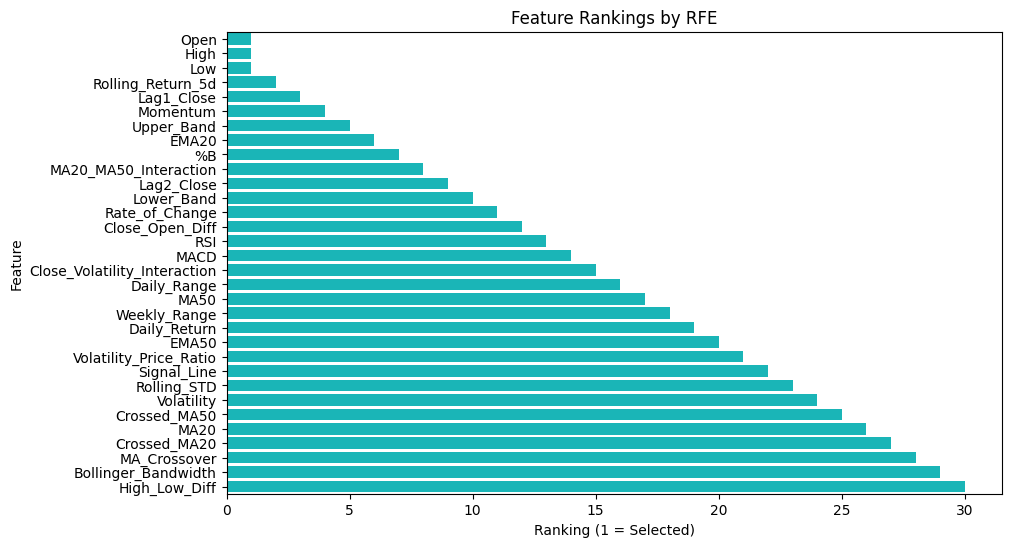

In [8]:
#display feature rankings
feature_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': final_rfe.ranking_
}).sort_values(by='Ranking')
plt.figure(figsize=(10, 6))
sns.barplot(x='Ranking', y='Feature', data=feature_ranking, color='darkturquoise')
plt.title('Feature Rankings by RFE')
plt.xlabel('Ranking (1 = Selected)')
plt.ylabel('Feature')
plt.show()

---
## Hyperparameter Tuning
Now that we have the final feature set, the next step is to optimize the XGBoost model hyperparameters.

#### Key Parameters to Tune:
- n_estimators: Number of trees (e.g., [50, 100, 200]).
- max_depth: Maximum depth of trees (e.g., [3, 5, 7, 10]).
- learning_rate: Step size shrinkage (e.g., [0.01, 0.1, 0.2]).
- subsample: Fraction of samples used for training each tree (e.g., [0.8, 1.0]).
- colsample_bytree: Fraction of features used per tree (e.g., [0.8, 1.0]).
- gamma: Minimum loss reduction required to make a further partition (e.g., [0, 0.1, 0.2]).

  
We will use Grid Search to systematically evaluate combinations of these hyperparameters and identify the top-performing models based on mean squared error (MSE).

In [9]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    verbose=2  # Print progress
)

# Fit Grid Search
grid_search.fit(X_train_rfe, y_train)

# Best model and parameters
best_xgb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {-grid_search.best_score_}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_d

In [10]:
# Extract all results from GridSearchCV
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values(by="mean_test_score", ascending=False)
top_3_params = cv_results.head(3)[['params', 'mean_test_score']]

print("Top 3 Hyperparameter Sets:")
pd.set_option('display.max_colwidth', None)
print(top_3_params)

Top 3 Hyperparameter Sets:
                                                                                                                 params  \
282  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.8}   
276   {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}   
280  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}   

     mean_test_score  
282        -0.031314  
276        -0.031381  
280        -0.031443  


In [11]:
# Evaluate the top 3 models on the test set
model_metrics = []
for i, row in top_3_params.iterrows():
    params = row['params']
    
    model = XGBRegressor(random_state=42, **params)
    model.fit(X_train_rfe, y_train)
    
    y_test_pred = model.predict(X_test_rfe)
    
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    model_metrics.append({
        "Model": f"Model_{i+1}",
        "MSE": round(mse, 6),
        "MAE": round(mae, 6),
        "R²": round(r2, 6)
    })

# Create a DataFrame with results
results_df = pd.DataFrame(model_metrics)
results_df

,Model,MSE,MAE,R²
0,Model_283,0.000107,0.006880,0.998895
1,Model_277,0.000112,0.007216,0.998846
2,Model_281,0.000108,0.006587,0.998889


----
## Retrain on Full dataset

This maximizes the predictive power of these models before testing them on the unseen dataset in the `model_comparison` notebook.

In [12]:
# Combine train and test sets into a full dataset
X_full = pd.concat([X_train_rfe, X_test_rfe], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)
print(f"Full dataset shape: {X_full.shape}")

Full dataset shape: (2608, 3)


In [13]:
model_nums = []
for i, row in top_3_params.iterrows():
    params = row['params']
    
    # Train the model on the full dataset
    model = XGBRegressor(random_state=42, **params)
    model.fit(X_full, y_full)
    
    # Save the model
    joblib.dump(model, f"../models/EURUSD_daily/xgb_model_full_{i+1}.joblib")
    model_nums.append(i+1)
    print(f"Model {i+1} saved as 'xgb_model_full_{i+1}.joblib")

Model 283 saved as 'xgb_model_full_283.joblib
Model 277 saved as 'xgb_model_full_277.joblib
Model 281 saved as 'xgb_model_full_281.joblib


In [14]:
# Verify saved models and their hyperparameters
for i in model_nums:
    model = joblib.load(f"../models/EURUSD_daily/xgb_model_full_{i}.joblib")
    print(f"Loaded Model {i} with Hyperparameters: {model.get_params()}\n\n")

Loaded Model 283 with Hyperparameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 50, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


Loaded Model 277 with Hyperparameters: {'objective': 'reg:squarederror